# 1. Importing Libraries

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.neighbors import NearestNeighbors

# from keras.applications.xception import Xception,preprocess_input
# import tensorflow as tf
# from keras.preprocessing import image
# from keras.layers import Input
# from keras.backend import reshape
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

/opt/conda/envs/cs282/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get Past Week Customer Transactions

In [3]:
import cudf
train = cudf.read_csv('/cs282/shared/h-and-m-personalized-fashion-recommendations/transactions_train.csv')
train['customer_id'] = train['customer_id'].str[-16:].str.hex_to_int().astype('int64')
train['article_id'] = train.article_id.astype('int32')
train.t_dat = cudf.to_datetime(train.t_dat)
train = train[['t_dat','customer_id','article_id']]
train.to_parquet('train.pqt',index=False)
print( train.shape )
train.head()

(31788324, 3)


,t_dat,customer_id,article_id
0,2018-09-20,-6846340800584936,663713001
1,2018-09-20,-6846340800584936,541518023
2,2018-09-20,-8334631767138808638,505221004
3,2018-09-20,-8334631767138808638,685687003
4,2018-09-20,-8334631767138808638,685687004


In [4]:
tmp = train.groupby('customer_id').t_dat.max().reset_index()
tmp.columns = ['customer_id','max_dat']
train = train.merge(tmp,on=['customer_id'],how='left')
train['diff_dat'] = (train.max_dat - train.t_dat).dt.days
train = train.loc[train['diff_dat']<=6]
print('Train shape:',train.shape)

Train shape: (5181535, 5)


In [5]:
train2 = train[["customer_id", "article_id"]]
train2 = train2.to_pandas()
train2.head()

,customer_id,article_id
35,8144921020642171327,682739001
36,8144921020642171327,626263014
37,8144921020642171327,626441006
38,8144921020642171327,592959010
39,8144921020642171327,719610002


In [6]:
train_dict = train2.groupby('customer_id')['article_id'].apply(set).to_dict()
i = 0
for key, values in train_dict.items():
    print(key, values)
    i += 1
    if i == 5:
        break

-9223352921020755230 {673396002, 812167004}
-9223343869995384291 {908292002, 903926002, 910601003, 865929007}
-9223321797620987725 {610776035, 580600006}
-9223319430705797669 {633130023, 646592007, 562245001, 470985003, 554477005, 646592013, 672625006, 504155001}
-9223308614576639426 {750423005}


In [7]:
print(train2[train2["customer_id"] == -9223352921020755230])
print(train2[train2["customer_id"] == -9223343869995384291])
print(train2[train2["customer_id"] == -9223319430705797669])
print(len(train_dict))

                  customer_id  article_id
31097798 -9223352921020755230   673396002
31097799 -9223352921020755230   812167004
                  customer_id  article_id
31297836 -9223343869995384291   903926002
31297837 -9223343869995384291   865929007
31297838 -9223343869995384291   908292002
31418956 -9223343869995384291   908292002
31506082 -9223343869995384291   910601003
                 customer_id  article_id
2746000 -9223319430705797669   562245001
2746001 -9223319430705797669   646592007
2746002 -9223319430705797669   504155001
2746003 -9223319430705797669   554477005
2746004 -9223319430705797669   633130023
2746005 -9223319430705797669   646592013
2746006 -9223319430705797669   672625006
2746479 -9223319430705797669   470985003
1362281


In [8]:
print(train2[train2["customer_id"] == -9215083819304503832])
print(train2[train2["customer_id"] == -9201668048266951831])
print(train2[train2["customer_id"] == -9154254125480714488])
print(train2[train2["customer_id"] == -9134595928930398261])
print(train2[train2["customer_id"] == -9126271852113924926])
print(train2[train2["customer_id"] == -9124766797201729069])
print(train2[train2["customer_id"] == -9102709710855657660])
print(train2[train2["customer_id"] == -9099400398318400386])

                  customer_id  article_id
28461560 -9215083819304503832   880333001
                  customer_id  article_id
24223591 -9201668048266951831   212629004
                  customer_id  article_id
25343013 -9154254125480714488   610776001
25343014 -9154254125480714488   610776001
25343015 -9154254125480714488   610776001
25343016 -9154254125480714488   610776001
                  customer_id  article_id
28798063 -9134595928930398261   610776001
                  customer_id  article_id
25466360 -9126271852113924926   537732001
                  customer_id  article_id
29336382 -9124766797201729069   877369001
29336383 -9124766797201729069   877369001
                  customer_id  article_id
23148868 -9102709710855657660   568020001
                 customer_id  article_id
7528420 -9099400398318400386   470985010


# 2. Loading and Preprocessing of Data

In [9]:
images_dir = '/cs282/shared/h-and-m-personalized-fashion-recommendations/images'

In [10]:
data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

def getImagePaths(path):
    """
    Function to Combine Directory Path with individual Image Paths
    
    parameters: path(string) - Path of directory
    returns: image_names(string) - Full Image Path
    """
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names

def preprocess_img(img_path):
    dsize = (225,225)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize,interpolation=cv2.INTER_NEAREST)  
    new_image=data_transforms(new_image)
    new_image=new_image[None,:]
    # new_image=np.expand_dims(new_image,axis=0)
    # new_image=torch.from_numpy(new_image).float() # change preprocessing...
    # new_image=new_image.permute((0, 3, 1, 2))
    return new_image

def load_data():
    img_paths=[]
    # img_paths=getImagePaths(images_dir)[:10000]
    img_paths=getImagePaths(images_dir)
    return img_paths

# 3. Defining model and extracting feature for all the training data

In [11]:
class ResNetPool(nn.Module):
    def __init__(self):
        super(ResNetPool, self).__init__()
        original_model = models.resnet18(pretrained=True)
        # print(original_model)
        self.features = nn.Sequential(
            *list(original_model.children())[:-1]
        )
    def forward(self, x):
        x = self.features(x)
        return x

def model():
    model = models.resnet18(pretrained=True)
    # model = ResNetPool()
    model.eval()
    return model

def feature_extraction(image_data,model):
    features=model(image_data)
    features=features.detach().numpy()
    # features=features.flatten()
    # print(features.shape)
    return features

# 4. Finding the similar image through LSH and cosine similarity

In [12]:
def result_vector_cosine(model,feature_vector,new_img):
    new_feature = model(new_img)
    new_feature = new_feature.detach().numpy()
    new_feature = new_feature.flatten()
    N_result = 12
    nbrs = NearestNeighbors(n_neighbors=N_result, metric="cosine").fit(feature_vector)
    distances, indices = nbrs.kneighbors([new_feature])
    
    return(distances, indices)

## remove articles not in images

In [13]:
from pathlib import Path

img_paths=load_data()
img_paths_set = set([Path(p).stem for p in img_paths])
print(len(img_paths_set))

img_dirs = set(os.listdir('/cs282/shared/h-and-m-personalized-fashion-recommendations/images/'))

remove_dict = {}
for i, (customer, articles) in enumerate(train_dict.items()):
    for article in articles:
        article_name = '0' + str(article)
        if article_name not in img_paths_set:
            # print(customer, article_name)
            if customer not in remove_dict:
                remove_dict[customer] = set([article])
            else:
                remove_dict[customer].add(article)
    if i % 200000 == 0:
        print("progress {}th customers done".format(i))

original_customer_len = len(train_dict)
# print(remove_dict)
for customer, articles in remove_dict.items():
    for article in articles:
        train_dict[customer].discard(article)
    if len(train_dict[customer]) == 0:
        del train_dict[customer]

print("remove {} of customers from dict".format(original_customer_len - len(train_dict)))
# input_show(cv2.imread(img_paths[1000]))

105100
progress 0th customers done
progress 200000th customers done
progress 400000th customers done
progress 600000th customers done
progress 800000th customers done
progress 1000000th customers done
progress 1200000th customers done
remove 1074 of customers from dict


In [30]:
def input_show(data):
    plt.figure()
    plt.title("Query Image")
    plt.imshow(data)

def show_result(data,result):
    fig = plt.figure(figsize=(12,8))
    for i in range(0,12):
        index_result=result[0][i]
        plt.subplot(3,4,i+1)
        plt.imshow(cv2.imread(data[index_result]))
    plt.show()

path_dict = {} # {article: article_path}
for p in img_paths:
    path_dict[Path(p).stem[1:]] = p

# print(path_dict)
# print(img_paths)

main_model=model()
# print(main_model)

similarities = {}

inputs = []
for i, article in enumerate(img_paths):
    new_img=preprocess_img(article)
    inputs.append(new_img)
    # features[key]=feature_extraction(new_img,main_model)
    if i % 10000 == 0 and i != 0:
        print("done processing image for {}th articles".format(i))
        # break

inputs = torch.stack(inputs)
inputs = inputs.squeeze(1)

# features = feature_extraction(inputs,main_model)

i = 0
batch_size = 6400
features = []
# print(inputs.shape)
while i < len(inputs):
    if len(features) == 0:
        features = feature_extraction(inputs[i:i+batch_size],main_model)
    else:
        # print(features.shape, (feature_extraction(inputs[i:i+batch_size],main_model).shape))
        features = np.concatenate((features, feature_extraction(inputs[i:i+batch_size],main_model)))
    i += batch_size


# print(features.shape)
customer_predictions = {}
for i, (customer, articles) in enumerate(train_dict.items()):
    distances = []
    results = []
    for article in articles:
        article = str(article)
        distance, result=result_vector_cosine(main_model,features,preprocess_img(path_dict[article]))
        # print(distance, result)
        distances += distance[0].tolist()
        results += result[0].tolist()
        # input_show(cv2.imread(path_dict[article]))
        # show_result(img_paths,result)

    # print(distances)
    # print(results)

    distances = np.array(distances)
    results = np.array(results)
    inds = distances.argsort()
    sorted_results = results[inds]
    # print(sorted_results)
    # print(sorted_results.tolist())
    results_no_duplicate = list(dict.fromkeys(sorted_results.tolist()))
    results_no_duplicate = results_no_duplicate[:12]
    # print(results_no_duplicate)
    
    results_articles = [Path(img_paths[i]).stem for i in results_no_duplicate]
    customer_predictions[customer] = results_articles
    # break
    if i % 200000 == 0:
        print("progress {}th customers done finding similarity".format(i))

i = 0
for key, values in customer_predictions.items():
    print(key, values)
    i += 1
    if i == 5:
        break

# 5. Result
## Vector Cosine

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

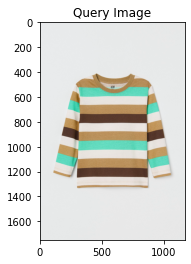

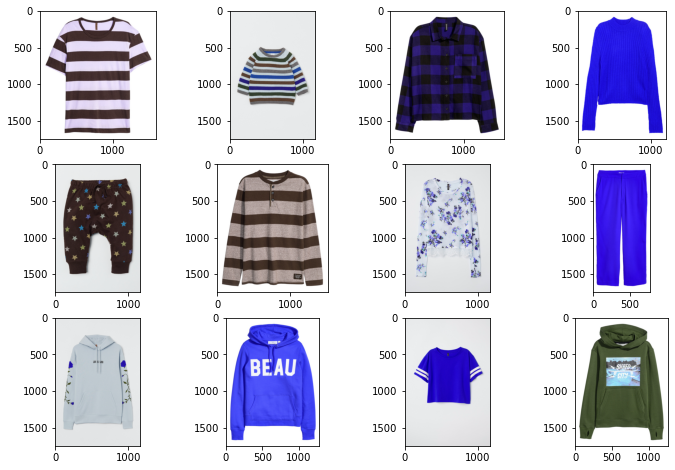

In [63]:
def input_show(data):
    plt.title("Query Image")
    plt.imshow(data)
  
def show_result(data,result):
    fig = plt.figure(figsize=(12,8))
    for i in range(0,12):
        index_result=result[0][i]
        plt.subplot(3,4,i+1)
        plt.imshow(cv2.imread(data[index_result]))
    plt.show()

def main():  
    features=[]
    img_paths=load_data()
    main_model=model()
    #Limiting the data for training
    for i in img_paths[:999]:
        new_img=preprocess_img(i)
        features.append(feature_extraction(new_img,main_model))
    feature_vec = np.array(features)
    result=result_vector_cosine(main_model,feature_vec,preprocess_img(img_paths[1000]))
    input_show(cv2.imread(img_paths[1000]))
    show_result(img_paths,result)
  

if __name__=='__main__':
    main()